<a href="https://colab.research.google.com/github/kim-suwan/statistic-class/blob/main/Mid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import numpy as np # 선형 대수를 위한 패키지
import pandas as pd # 데이터에 접근을 위한 패키지
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import lightgbm as lgb

In [112]:
insurance = pd.read_csv('/var/insurance_claims.csv') # 보험데이터를 불러온다

In [113]:
insurance.head() # 39개의 열과 1000개의 데이터를 가지고 있다

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,25-01-2015,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,21-01-2015,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,22-02-2015,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,10-01-2015,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,17-02-2015,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [114]:
insurance.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


In [117]:
# missing values 를 찾는 함수를 만들어본다.
def missing_values_table(df):
        
        mis_val = df.isnull().sum() # Total missing values 계산
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)  # missing values의 비율을 계산
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  # 위의 결과로 테이블을 만든다.
        
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #열의 이름을 다시 지정해준다.
        
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)     #  % of missing descending 으로 다시 배열해준다.
        
       
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")       # 요약된 정보를 출력할 수 있게 print 함수를 보기좋게 글자까지 넣어서 써준다.
         
        return mis_val_table_ren_columns


In [116]:
missing_values = missing_values_table(insurance)
missing_values 
 # 이렇게 열심히 했는데 missing value 는 없는 것으로 나온다.  

Your selected dataframe has 39 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [121]:
 # 데이터 분석을 용이하게 만들기 위해 라벨 인코딩을 해본다.
 # 만약 2 이하의 unique categories 가 있다면 라벨 인코딩을 수행한다.
 # 먼저 training dada에 적용 실험해 보고 training and testing data 둘다 바꿔준다.
    # 그리고 몇개의 열이나 라벨인코딩이 되는지 확인하는 작업을 수행한다.
le = LabelEncoder()
le_count = 0


for col in insurance:
    if insurance[col].dtype == 'object':
        
        if len(list(insurance[col].unique())) <= 2:
            
            le.fit(insurance[col])
            
            insurance[col] = le.transform(insurance[col])
            
            
            
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

#결고 적으로 2개의 라벨이 인코딩 된다.

2 columns were label encoded.


In [122]:
insurance.head()
# 결과를 확인해보면 insured_sex 열과 fraud_reported 열이 바뀐것을 알 수 있다.

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,1,MD,craft-repair,sleeping,husband,53300,0,25-01-2015,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,1,MD,machine-op-inspct,reading,other-relative,0,0,21-01-2015,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,0,PhD,sales,board-games,own-child,35100,0,22-02-2015,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,0,PhD,armed-forces,board-games,unmarried,48900,-62400,10-01-2015,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,1,Associate,sales,board-games,unmarried,66000,-46000,17-02-2015,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,0


In [53]:
insurance.corr()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,fraud_reported
months_as_customer,1.000000,0.922098,0.057555,0.026807,0.005018,0.015498,0.017895,0.060925,0.006399,0.020209,0.070639,0.014736,-0.010162,0.058383,0.062108,0.065329,0.034940,0.061013,-0.000292,0.020544
age,0.922098,1.000000,0.059413,0.029188,0.014404,0.018126,0.025604,0.073337,-0.007075,0.007368,0.087161,0.022102,-0.015679,0.052359,0.069863,0.075522,0.060898,0.062588,0.001354,0.012143
policy_number,0.057555,0.059413,1.000000,-0.006738,0.022566,0.008968,0.007083,0.004564,0.009802,-0.005669,0.000113,0.013432,-0.004558,-0.012661,-0.018009,-0.008762,-0.010678,-0.020184,-0.000183,-0.029443
policy_deductable,0.026807,0.029188,-0.006738,1.000000,-0.003245,0.010870,0.004545,-0.009733,0.035212,-0.023544,0.060935,0.051214,-0.022765,0.066639,0.022839,0.039107,0.064792,0.005269,0.026105,0.014817
policy_annual_premium,0.005018,0.014404,0.022566,-0.003245,1.000000,-0.006247,0.032354,0.038853,-0.013738,0.023547,-0.001578,-0.045991,0.026780,0.002332,0.009094,-0.017633,-0.011654,0.020246,-0.049226,-0.014480
umbrella_limit,0.015498,0.018126,0.008968,0.010870,-0.006247,1.000000,0.019671,0.010688,-0.047268,-0.024056,-0.023257,-0.021270,0.022743,-0.006738,-0.040344,-0.045412,-0.023790,-0.038584,0.009893,0.058622
insured_zip,0.017895,0.025604,0.007083,0.004545,0.032354,0.019671,1.000000,-0.036942,0.006303,0.049372,0.008274,0.027448,0.028695,0.019805,-0.033873,-0.017495,-0.006841,-0.041083,-0.032736,0.019368
insured_sex,0.060925,0.073337,0.004564,-0.009733,0.038853,0.010688,-0.036942,1.000000,-0.020494,-0.021705,0.019290,0.018793,-0.020297,0.042463,-0.023727,0.000924,-0.014868,-0.029609,-0.028247,0.030873
capital-gains,0.006399,-0.007075,0.009802,0.035212,-0.013738,-0.047268,0.006303,-0.020494,1.000000,-0.046904,-0.016406,0.061643,0.055829,-0.017651,0.015980,0.025934,-0.000779,0.015836,0.031398,-0.019173
capital-loss,0.020209,0.007368,-0.005669,-0.023544,0.023547,-0.024056,0.049372,-0.021705,-0.046904,1.000000,-0.025054,-0.014895,-0.024418,-0.041330,-0.036060,-0.046060,-0.022863,-0.032665,-0.056615,-0.014863


In [12]:
#특이한 값들을 찾기 위해 다음과 같이 수행하여 열을 조정해주어야 한다.
colum_name =[]
unique_value=[]

for col in insurance:
    if insurance[col].dtype == 'object':
       
        colum_name.append(str(col)) 
        unique_value.append(insurance[col].nunique())
table= pd.DataFrame()
table['Col_name'] = colum_name
table['Value']= unique_value
            
table=table.sort_values('Value',ascending=False)
table

,Col_name,Value
15,incident_location,1000
0,policy_bind_date,951
8,incident_date,60
19,auto_model,39
6,insured_hobbies,20
18,auto_make,14
5,insured_occupation,14
4,insured_education_level,7
14,incident_city,7
13,incident_state,7


In [84]:
insurance.drop(['incident_location','policy_bind_date','incident_date','auto_model','insured_occupation','policy_number'],axis=1,inplace=True)
# 위의 결과들을 보고 유용하지 못한 열들을 제거한다.

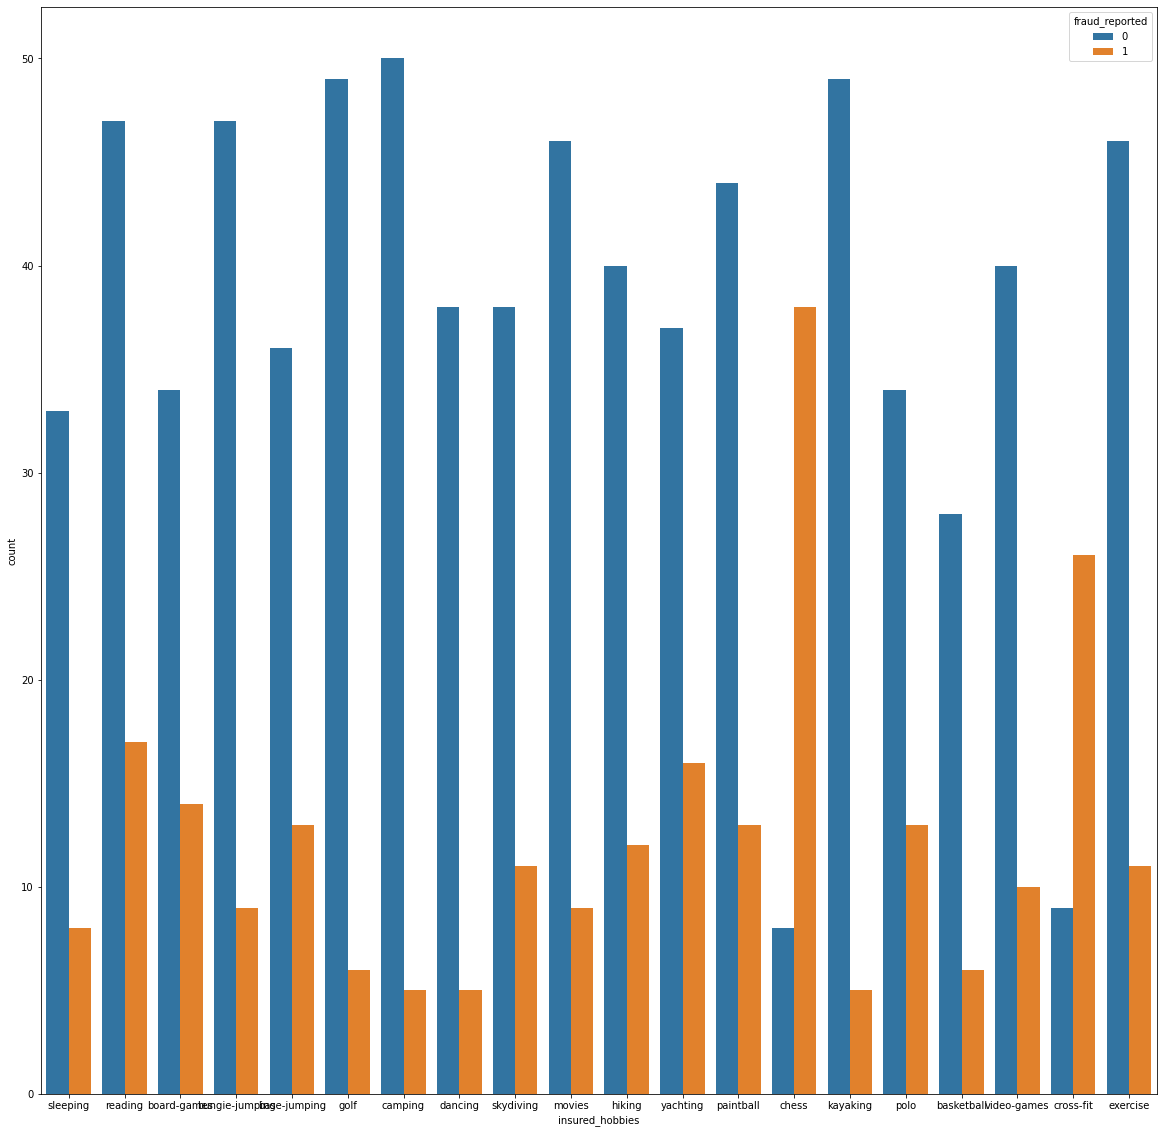

In [85]:
f, ax = plt.subplots(figsize=(20, 20))
sns.countplot(x='insured_hobbies',hue='fraud_reported',data=insurance)

In [86]:
insurance['insured_hobbies']=insurance['insured_hobbies'].apply(lambda x :'Other' if x!='chess' and x!='cross-fit' else x)

#.체스나 크로스핏 결과가 특이하게 나오기 떄문에 보험에 가입 한 취미가 체스 및 크로스 핏이 아닌 경우 추가 '기타'열을 생성한다.

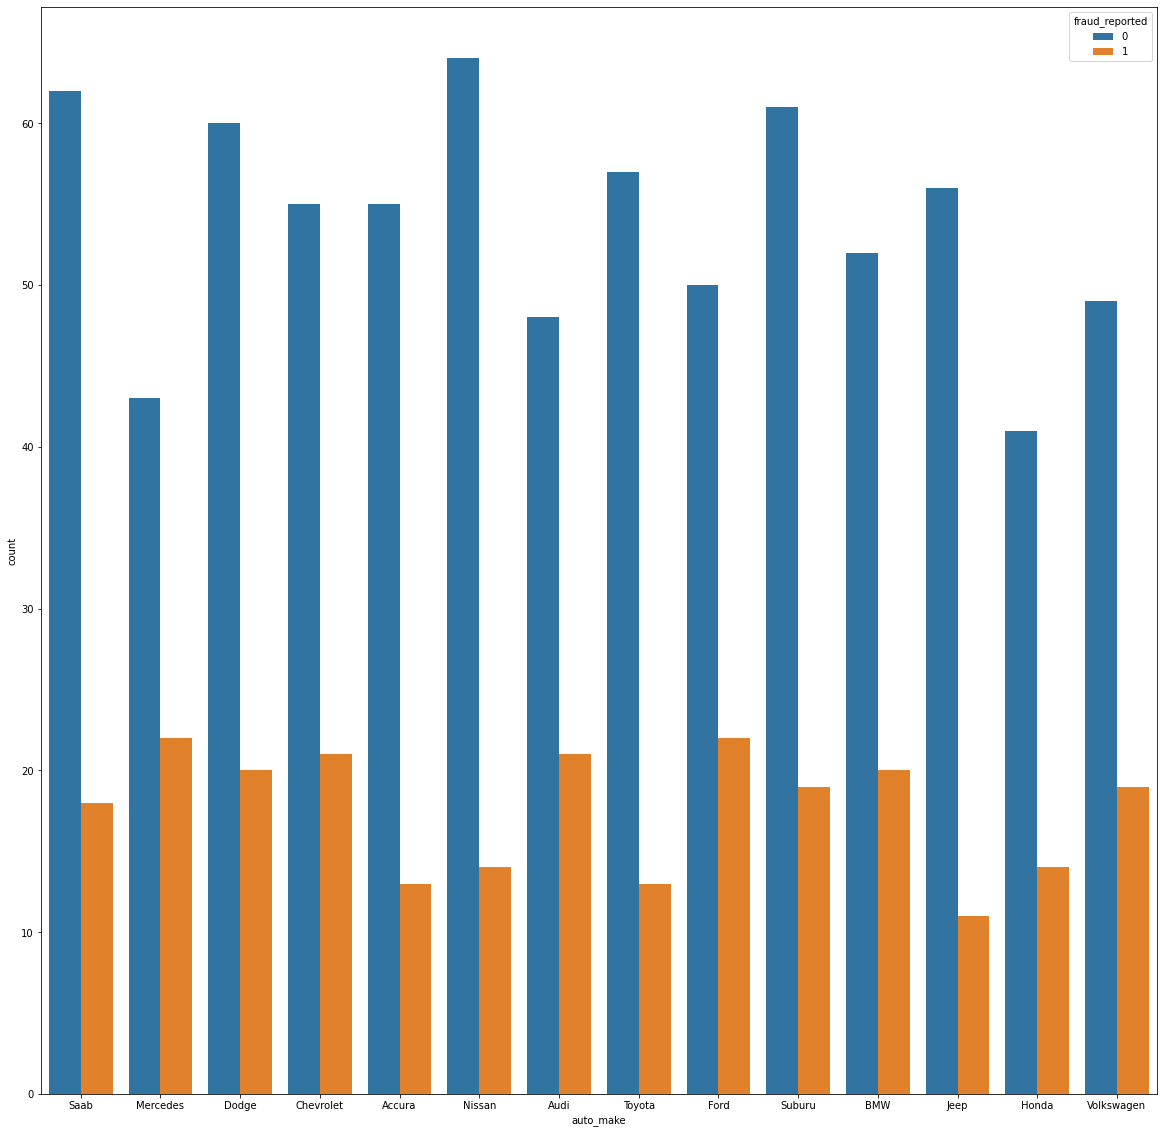

In [87]:
f, ax = plt.subplots(figsize=(20, 20))
sns.countplot(x='auto_make',hue='fraud_reported',data=insurance)

# auto_make에는 딱히 특이점을 갖는 변수가 없다.

In [88]:
insurance['insured_hobbies'].unique()

array(['Other', 'chess', 'cross-fit'], dtype=object)

In [89]:
insurance = pd.get_dummies(insurance)
print('Training Features shape: ', insurance.shape)

# 그리고 데이터 분석을 위해 dummies variable들을 만들어 준다.

Training Features shape:  (1000, 92)


In [123]:
y=insurance['fraud_reported']
X= insurance.drop('fraud_reported',axis=1)

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [69]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, insurance):
    y_true = insurance.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [70]:
def run_lgb(X_train, X_test, y_train, y_test, test_df):
    params = {
        "objective" : "binary",
       "n_estimators":1000,
       "reg_alpha" : 0.5,
       "reg_lambda":0.5,
       "n_jobs":-1,
       "colsample_bytree":.8,
       "min_child_weight":8,
       "subsample":0.8715623,
       "min_data_in_leaf":30,
       "nthread":4,
       "metric" : "f1",
       "num_leaves" : 10,
       "learning_rate" : 0.01,
       "verbosity" : -1,
       "seed": 60,
       "max_bin":60,
       'max_depth':3,
       'min_gain_to_split':.0222415,
       'scale_pos_weight':1.4,
        'bagging_fraction':0.8
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_test, label=y_test)
    evals_result = {}
    model = lgb.train(params, lgtrain, 10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result,feval=lgb_f1_score)
    
    pred_test_y = model.predict(test_df, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

    # train data와 test data를 나누고 모델을 설정하고 반복횟수를 설정한다.

In [71]:
pred_test, model, evals_result = run_lgb(X_train, X_test, y_train, y_test, X_test)
print("LightGBM Training Completed...")

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's f1: 0.727848	valid_1's f1: 0.646154
[200]	training's f1: 0.775819	valid_1's f1: 0.759494
Early stopping, best iteration is:
[119]	training's f1: 0.786325	valid_1's f1: 0.710145
LightGBM Training Completed...


In [72]:
from sklearn.metrics import roc_auc_score

In [73]:
roc_auc_score(y_test,pred_test)

# 정확도가 무려 90%나 되므로 꽤나 정확하다고 할 수 있다(?)

0.9019875776397516

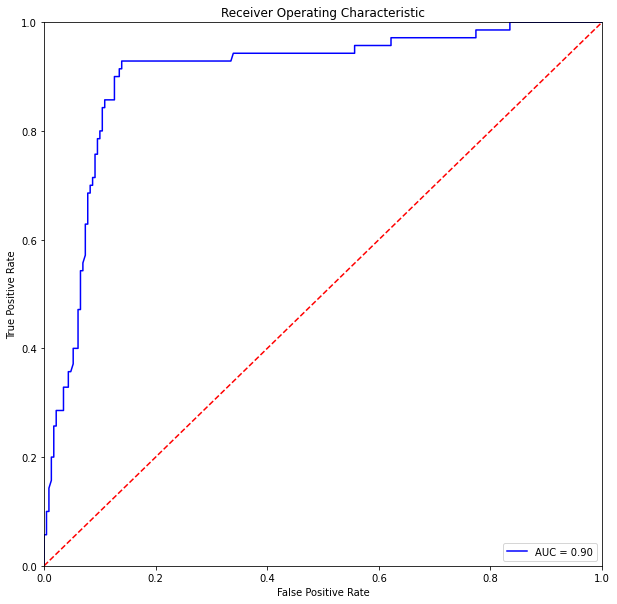

In [74]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_test)
roc_auc = metrics.auc(fpr, tpr)
f, ax = plt.subplots(figsize=(10, 10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Plot feature importances...


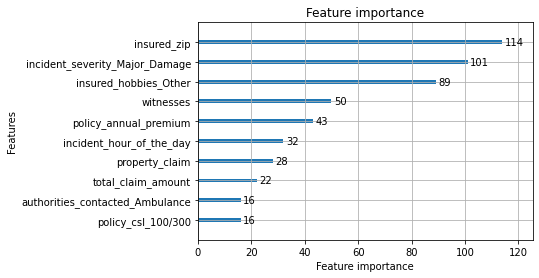

In [75]:
print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=10)
plt.show()

# 보험사기에 끼치는 중요한 요소들의 순서를 알 수 있다.